100%|██████████| 11/11 [00:19<00:00,  1.82s/it]


<IPython.core.display.Javascript object>


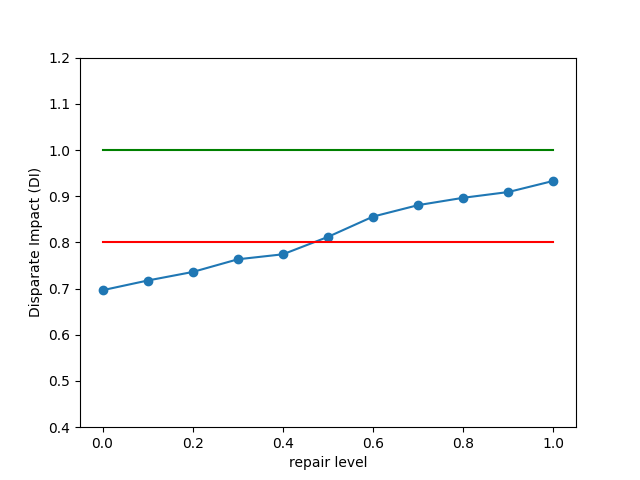

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals

import matplotlib.pyplot as plt

import sys
sys.path.append("../")
import warnings

import numpy as np
from tqdm import tqdm

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC as SVM
from sklearn.preprocessing import MinMaxScaler

from aif360.algorithms.preprocessing import DisparateImpactRemover
from aif360.datasets import AdultDataset
from aif360.metrics import BinaryLabelDatasetMetric


protected = 'sex'
ad = AdultDataset(protected_attribute_names=[protected],
    privileged_classes=[['Male']], categorical_features=[],
    features_to_keep=['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week'])

scaler = MinMaxScaler(copy=False)

test, train = ad.split([16281])
train.features = scaler.fit_transform(train.features)
test.features = scaler.fit_transform(test.features)

index = train.feature_names.index(protected)

DIs = []
for level in tqdm(np.linspace(0., 1., 11)):
    di = DisparateImpactRemover(repair_level=level)
    train_repd = di.fit_transform(train)
    test_repd = di.fit_transform(test)

    X_tr = np.delete(train_repd.features, index, axis=1)
    X_te = np.delete(test_repd.features, index, axis=1)
    y_tr = train_repd.labels.ravel()

    lmod = LogisticRegression(class_weight='balanced', solver='liblinear')
    lmod.fit(X_tr, y_tr)

    test_repd_pred = test_repd.copy()
    test_repd_pred.labels = lmod.predict(X_te)

    p = [{protected: 1}]
    u = [{protected: 0}]
    cm = BinaryLabelDatasetMetric(test_repd_pred, privileged_groups=p, unprivileged_groups=u)
    DIs.append(cm.disparate_impact())
    
%matplotlib notebook

plt.plot(np.linspace(0, 1, 11), DIs, marker='o')
plt.plot([0, 1], [1, 1], 'g')
plt.plot([0, 1], [0.8, 0.8], 'r')
plt.ylim([0.4, 1.2])
plt.ylabel('Disparate Impact (DI)')
plt.xlabel('repair level')
plt.show()